In [1]:
import matplotlib
matplotlib.use('Agg')
import numpy as np
from numpy import exp, log, pi, log10
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
matplotlib.rc('figure', dpi=120)
import joblib
mem = joblib.Memory('.', verbose=False)


Intrinsic distributions 
==============================

* Lets assume the true value is x=2.

* But our measurement is uncertain, so it gives us two solutions: x=2 and x=-2.
* If we measure many objects, can we determine the fraction of x>0?


In [2]:
def generate_samples():
    return np.concatenate((np.random.normal(-2, 0.5, size=500), np.random.normal(2, 0.5, size=500)))

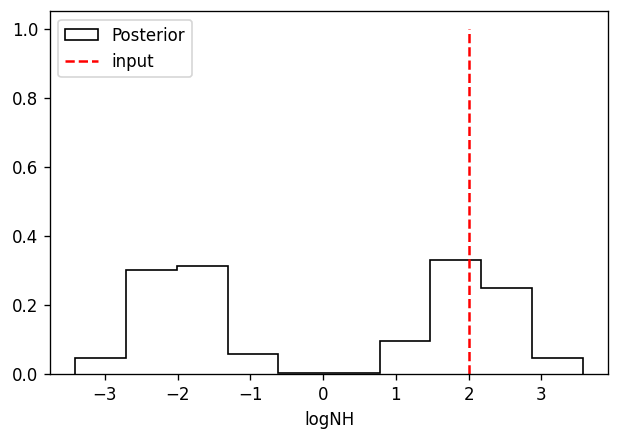

In [3]:
x = generate_samples()
plt.figure()
plt.hist(x, density=True, histtype='step', color='k', label='Posterior')
plt.vlines(2, 0, 1, color='r', ls='--', label='input')
plt.legend(loc='upper left')
plt.xlabel('logNH');

## Lets generate a sample:

In [4]:
np.random.seed(42)

sample = np.array([generate_samples() for i in range(15)])

No handles with labels found to put in legend.


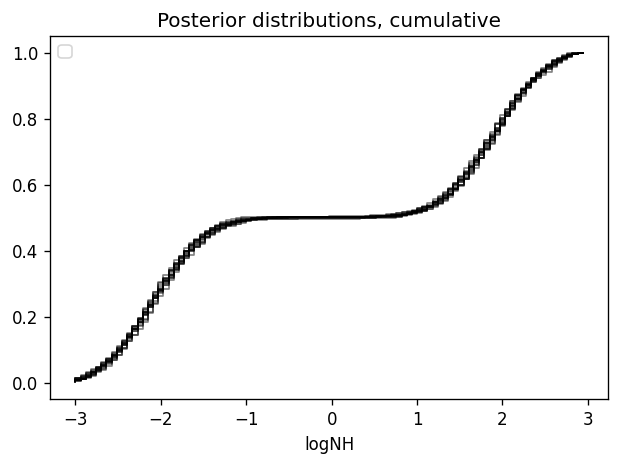

In [5]:
bins = np.linspace(-3, 3, 100)

plt.figure()
plt.title("Posterior distributions, cumulative")
for i, xsamples in enumerate(sample):
    values, edges = np.histogram(xsamples, bins=bins, density=True)
    plt.plot(edges[:-1], values.cumsum() / values.sum(), drawstyle='steps-pre', color='k', lw=1, alpha=0.5)

#plt.vlines(2, 0, 5, color='r', ls='--', label='input')
plt.legend(loc='upper left')
plt.xlabel('logNH');

# Methods to estimate intrinsic distribution

## Bad method 1: Stack histograms

Here, the histograms are added on top of each other. Equivalently, all the posterior samples are merged.

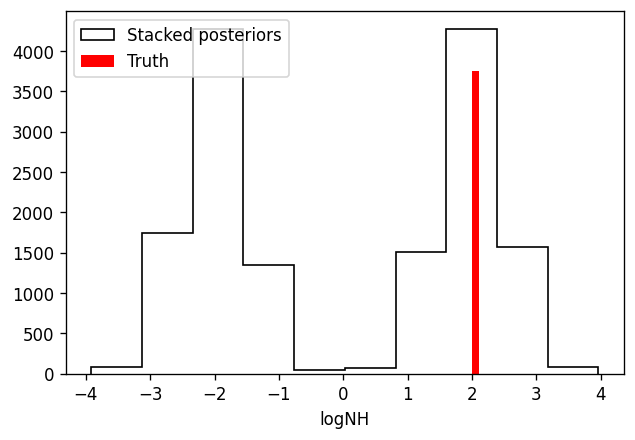

In [6]:
plt.figure()
allsamples = np.concatenate(sample)
plt.hist(allsamples, label='Stacked posteriors', histtype='step', color='k')
plt.hist(np.ones(len(allsamples)//4) * 2, label='Truth', color='r')

plt.legend(loc='upper left')
plt.xlabel('logNH');

* The stacked histograms **mixes measurement uncertainty with intrinsic distribution**
* This wrongly suggests that there are logNH<0 values in our sample

## Bad method 2: randomly sample a true point from each posterior

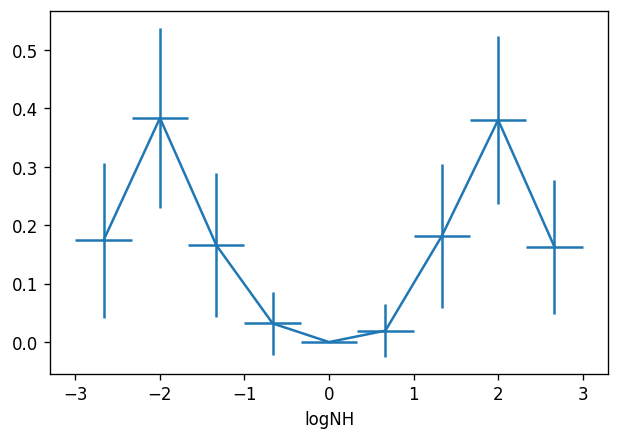

In [7]:
bins = np.linspace(-3, 3, 10)

plt.figure()
allhists = []
for i in range(100):
    values, edges = np.histogram([np.random.choice(xsamples) for xsamples in sample], bins=bins, density=True)
    allhists.append(values)

plt.errorbar(
    x=(bins[1:] + bins[:-1]) / 2,
    xerr=(bins[1:] - bins[:-1]) / 2,
    y=np.mean(allhists, axis=0),
    yerr=np.std(allhists, axis=0),
)
plt.xlabel('logNH');

* The randomly sampled posteriors also **mixes measurement uncertainty with intrinsic distribution**
* This wrongly suggests that there are logNH<0 values in our sample
* It also underestimates the uncertainties, and suggests the uncertainties are uncorrelated

## Hierarchical Bayesian model

Lets define a simple population model, where we have some density at <0 and >0 (two bins).

We only have one parameter, defining the fraction above 0. You can later expand this to more fractions.


In [8]:
posteriors_above = (sample > 0).mean(axis=1)
print('fraction of the posterior at x>0 for each dataset:\n', posteriors_above)

def loglike_population(fraction):
    prob = posteriors_above * fraction + (1 - fraction) * (1 - posteriors_above)
    return log(prob + 1e-100).sum()

def transform_population(u):
    return u # uniform from 0 to 1

paramnames_population = ['fraction']

from ultranest import ReactiveNestedSampler
import logging
logging.getLogger('ultranest').setLevel(logging.ERROR)
sampler = ReactiveNestedSampler(paramnames_population, loglike_population, transform=transform_population)
population_results = sampler.run()


fraction of the posterior at x>0 for each dataset:
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+01  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -10.4 +- 4.494e-15
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.


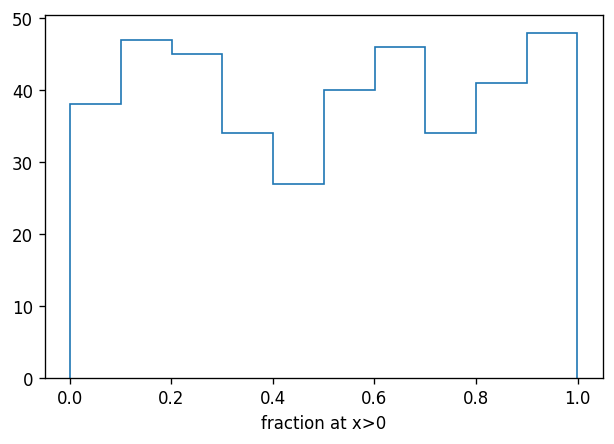

In [9]:
plt.figure()
plt.hist(population_results['samples'][:,0], histtype='step');
plt.xlabel('fraction at x>0');

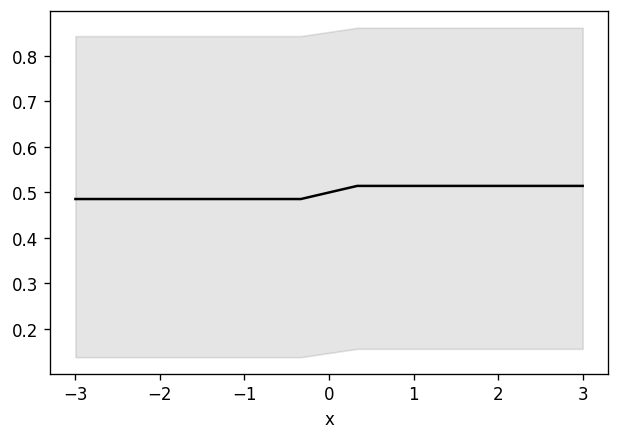

In [10]:
plt.figure()
from ultranest.plot import PredictionBand

band = PredictionBand(bins)
for fraction in population_results['samples'][:,0]:
    band.add(np.where(bins < 0, 1 - fraction, fraction))

band.line(color='k')
band.shade(color='k', alpha=0.1)
plt.xlabel('x');

## Takeaways

* The Hierarchical Bayesian model allows
  * the option that all have x>0
  * the option that all have x<0
  * and gives them equal probability (see posterior of fraction two plots up)
* Here, the measurement uncertainty is separated from the population distribution, because we average over each sample's posterior.
* This performs more reliably than stacking or sampling from posterior samples. However, a population distribution needs to be assumed.
